In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

Configuration for generating dataset with seed for reproducibility

In [2]:
SEED = 177013               #seed for reproducibility
NUM_OF_SAMPLES = 1000       #number of samples in dataset
TIME_INTERVAL = [0.0, 2*np.pi]      #interval for time
DISCR_OF_TIME = 10          #level of time discretization
OMEGA_MIN = 0               #minimal value for frequency (omega)
OMEGA_MAX = 10              #maximal value for frequency (omega)
AMPLITUDE_MIN = 1           #minimal value for amplitude (A)
AMPLITUDE_MAX = 1           #maximal value for amplitude (A)

#epochs are now just hardwritten and wasn't modified. I have some kind of remembering 
#what weights was best and it will use that
EPOCHS = 200

Sine function and generating dataset to only predict omega w

In [3]:
#sine dataset generator
def make_sine_dataset(N: int=NUM_OF_SAMPLES, t_interval: list=TIME_INTERVAL, t_k: int=DISCR_OF_TIME, w_min: int=OMEGA_MIN, w_max: int=OMEGA_MAX, seed=SEED ):
    rng = np.random.default_rng(seed)

    #evenly space time in t_k levels
    t_val = np.linspace(t_interval[0], t_interval[1], t_k)
    #generate N frequencies from [w_min ,w_max]
    w_val = rng.uniform(w_min, w_max, size=N)
    
    V, target = [], []

    #generate N samples of A*sin(w*t)
    for wi in w_val:
        Vi = 1 * np.sin(wi * t_val)
        V.append(np.array(Vi))
        target.append(np.array([wi]))

    #return tuple of arrays of 
    return np.array(V), np.array(target), t_val

Conversion dataset into tensors

In [4]:
V_np, tar_np, t_np = make_sine_dataset()

#np.arrays to tensors
X = torch.from_numpy(V_np).float()
y = torch.from_numpy(tar_np).float()
ds_full = TensorDataset(X, y)

Splitting data into train, val and test parts and loaders for each one

In [5]:
#spltting to train, val and test parts
ds_train, ds_val, ds_test = random_split(
    ds_full, [0.6, 0.2, 0.2],
    generator=torch.Generator().manual_seed(0)
)

batch = min(32, max(1, len(ds_train)))
train_loader = DataLoader(ds_train, batch_size=batch, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=batch, shuffle=False)
test_loader = DataLoader(ds_test, batch_size=batch, shuffle=False)

Positional encoding - almost copy of class PositionalEncoding from here (https://h-huang.github.io/tutorials/beginner/transformer_tutorial.html)
because we need somehow know the order for values.

In [6]:
#positional encoding (copy of pytorch tutorial)
#anti-permutation - for model to know order in time
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:x.size(1)].unsqueeze(0)

Trasnfromer model No.1 is created exactly like pytorch tutorial
- class Transformer - https://docs.pytorch.org/docs/stable/generated/torch.nn.Transformer.html#torch.nn.Transformer
- TransformerEncoderLayer - https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer
- TransformerEncoder - https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder

Shortly, i did this with big help from pytorch tutorial (just transformer part) - https://docs.pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html


In [7]:
#e-only transformer, head (w)
class TransformerModel1(nn.Module):
    def __init__(self, seq_len: int=1, d_model: int = 128, nhead: int = 4, num_layers: int = 2, dim_f: int = 128, dropout: float = 0.1):
        super().__init__()

        self.input_embedding = nn.Linear(1, d_model)
        self.position_encoding = PositionalEncoding(d_model, seq_len)       #creates order for time
        
        layer = nn.TransformerEncoderLayer(d_model, nhead, dim_f, dropout=dropout, batch_first=True)        #creates layers/blocks
        self.transformer_encoder = nn.TransformerEncoder(layer, num_layers)

        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, 1))     #normalization and prediction for w

    def forward(self, src):
        src = src.unsqueeze(-1)

        src = self.input_embedding(src)
        src = self.position_encoding(src)
        z = self.transformer_encoder(src)

        pool = z.mean(dim=1)
        output = self.head(pool)
        return output

Setup

In [8]:
#now i had some problem with running at graphical cards, i installed something wrong - i'll fix it later
#for now it's small dataset, so cpu... in future i'll do it for cuda
device = torch.device("cpu")

model = TransformerModel1(seq_len=DISCR_OF_TIME, d_model=128, nhead=4, num_layers=2, dim_f=256, dropout=0.1).to(device)

#mean squeared error - regression
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

Evaluation function

In [9]:
@torch.no_grad()
def evaluate(loader):
    model.eval()
    mse, mae, n = 0, 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        mse += torch.sum((pred - yb)**2).item()
        mae += torch.sum(torch.abs(pred - yb)).item()
        n += yb.numel()
    
    return mse / n, mae / n

In [10]:
@torch.no_grad()
def prediction_collecter_plot(loader, model, device):
    model.eval()
    y_true, y_pred = [], []
    
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pred = model(xb)
        y_true.append(yb.squeeze(-1).cpu())
        y_pred.append(pred.squeeze(-1).cpu())

    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)

    return y_true, y_pred

In [11]:
#main loop
best_val = float("inf")
best_state = None


for epoch in range(1, EPOCHS + 1):
    model.train()
    
    #training step
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()

    #validation steop
    val_mse, val_mae = evaluate(val_loader)
    if val_mse < best_val:
        best_val = val_mse
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 20 == 0:
        tr_mse, tr_mae = evaluate(train_loader)
        print(f"Epoch {epoch:3d}; Train MSE {tr_mse:.6f}, MAE {tr_mae:.6f}; Val MSE {val_mse:.6f}, MAE {val_mae:.6f}")

#load the best weights
model.load_state_dict(best_state)

#test step
test_mse, test_mae = evaluate(test_loader)
print(f"Test MSE {test_mse:.6f}, MAE {test_mae:.6f}")


Epoch  20; Train MSE 7.787553, MAE 2.409679; Val MSE 7.485546, MAE 2.374651
Epoch  40; Train MSE 7.611654, MAE 2.305039; Val MSE 7.826921, MAE 2.360110
Epoch  60; Train MSE 7.401181, MAE 2.269165; Val MSE 7.338805, MAE 2.272077
Epoch  80; Train MSE 5.762138, MAE 1.743313; Val MSE 5.574165, MAE 1.655842
Epoch 100; Train MSE 5.650550, MAE 1.716652; Val MSE 5.572633, MAE 1.674312
Epoch 120; Train MSE 5.616441, MAE 1.714973; Val MSE 5.515220, MAE 1.667958
Epoch 140; Train MSE 6.091115, MAE 1.875761; Val MSE 6.504351, MAE 1.918267
Epoch 160; Train MSE 4.866242, MAE 1.561513; Val MSE 5.514141, MAE 1.729301
Epoch 180; Train MSE 4.563811, MAE 1.424958; Val MSE 4.945902, MAE 1.499683
Epoch 200; Train MSE 4.867019, MAE 1.473372; Val MSE 5.681526, MAE 1.583594
Test MSE 4.865420, MAE 1.520109


I usually let the graph code be written with gpt with the conditions i want. I think this isn't wrong, is it?

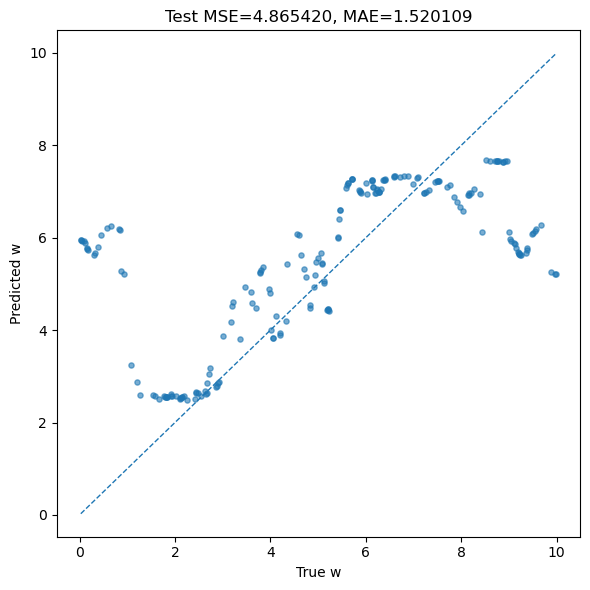

In [13]:
y_true, y_pred = prediction_collecter_plot(test_loader, model, device)

#plotting real and predicted values of w
plt.figure(figsize=(6,6))
plt.scatter(y_true.numpy(), y_pred.numpy(), s=14, alpha=0.6)
mn = min(y_true.min().item(), y_pred.min().item())
mx = max(y_true.max().item(), y_pred.max().item())
plt.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1)  # reference y=x
plt.xlabel("True w")
plt.ylabel("Predicted w")
plt.title(f"Test MSE={test_mse:.6f}, MAE={test_mae:.6f}")
plt.tight_layout()
plt.show()